Solve multiphase thermal/elastic problems using FEANet based on PAC

In [1]:
import pacnet.pac as pac

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce
from utils import plot
from data.dataset import ElasticityDataSet

In [5]:
class SACFEANet(nn.Module):
    def __init__(self, mode='thermal', kernel_size=3):
        super(SACFEANet, self).__init__()
        self.mode = mode
        self.h = 1. # pixel size
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        self.K_kernels = None
        self.f_kernels = None
        self.t_kernels = None
        self.materials = None
        
        self.sac_Knet = pac.PacPool2d(out_channels=self.ku*self.kf, kernel_size=kernel_size, padding=1, kernel_type='quad')
        self.sac_fnet = pac.PacPool2d(out_channels=self.kf,kernel_size=kernel_size, padding=1, kernel_type='quad') # body force
        self.sac_tnet = pac.PacPool2d(out_channels=self.kf,kernel_size=kernel_size, padding=1, kernel_type='quad') # traction force

        self.group_Knet = nn.Conv2d(in_channels=self.ku*self.kf, out_channels=self.kf, kernel_size=1, groups=self.ku, bias=False)
        self.group_Knet.weight.data.fill_(1.0)
        
    def thermal_elements(self, m):
        # only one material parameter, alpha
        alpha = m

        k11 = 4./6.*alpha.contiguous()
        k12 = -1./6.*alpha.contiguous()
        k13 = -2./6.*alpha.contiguous()
        k14 = -1./6.*alpha.contiguous()

        K = torch.cat(( k11.clone(), k12.clone(), k13.clone(), k14.clone(), 
                        k12.clone(), k11.clone(), k14.clone(), k13.clone(), 
                        k13.clone(), k14.clone(), k11.clone(), k12.clone(), 
                        k14.clone(), k13.clone(), k12.clone(), k11.clone()), dim=1)
        return torch.unsqueeze(K, dim=2)

    def elastic_elements(self, m):
        K11 = self.elastic_element11(m)
        K12 = self.elastic_element12(m)
        K21 = self.elastic_element21(m)
        K22 = self.elastic_element22(m)
        return torch.stack((K11, K12, K21, K22), dim=2) # create a new dimension

    def elastic_element11(self, m):
        # generate the layer of element stiffness matrix K11
        E = torch.unsqueeze(m[:, 0, :, :], dim=1)
        v = torch.unsqueeze(m[:, 1, :, :], dim=1)

        k11 = (E/16./(1-v*v)*(8.-8./3*v)).contiguous()
        k12 = (E/16./(1-v*v)*(-4.-4./3*v)).contiguous()
        k13 = (E/16./(1-v*v)*(-4.+4./3*v)).contiguous()
        k14 = (E/16./(1-v*v)*8./3*v).contiguous()

        K11 = torch.cat((k11.clone(), k12.clone(), k13.clone(), k14.clone(), 
                         k12.clone(), k11.clone(), k14.clone(), k13.clone(), 
                         k13.clone(), k14.clone(), k11.clone(), k12.clone(), 
                         k14.clone(), k13.clone(), k12.clone(), k11.clone()), dim=1) # cat in old dimension
        return K11

    def elastic_element12(self, m):
        # generate the layer of element stiffness matrix K12
        E = torch.unsqueeze(m[:, 0, :, :], dim=1)
        v = torch.unsqueeze(m[:, 1, :, :], dim=1)

        k11 = (E/8./(1-v)).contiguous()
        k12 = (E*(1-3*v)/8./(-1+v*v)).contiguous()

        K12 = torch.cat((k11.clone(), k12.clone(), -k11.clone(), -k12.clone(), 
                         -k12.clone(), -k11.clone(), k12.clone(), k11.clone(), 
                         -k11.clone(), -k12.clone(), k11.clone(), k12.clone(), 
                         k12.clone(), k11.clone(), -k12.clone(), -k11.clone()), dim=1)
        return K12

    def elastic_element21(self, m):
        # generate the layer of element stiffness matrix K21
        E = torch.unsqueeze(m[:, 0, :, :], dim=1)
        v = torch.unsqueeze(m[:, 1, :, :], dim=1)

        k11 = (E/8./(1-v)).contiguous()
        k12 = (E*(1-3*v)/8./(1-v*v)).contiguous()

        K21 = torch.cat((k11.clone(), k12.clone(), -k11.clone(), -k12.clone(), 
                         -k12.clone(), -k11.clone(), k12.clone(), k11.clone(), 
                         -k11.clone(), -k12.clone(), k11.clone(), k12.clone(), 
                         k12.clone(), k11.clone(), -k12.clone(), -k11.clone()), dim=1)

        return K21

    def elastic_element22(self, m):
        # generate the layer of element stiffness matrix K22
        E = torch.unsqueeze(m[:, 0, :, :], dim=1)
        v = torch.unsqueeze(m[:, 1, :, :], dim=1)

        k11 = (E*(-3.+v)/6./(-1+v*v)).contiguous()
        k12 = (-E*v/6./(-1+v*v)).contiguous()
        k13 = (E*(3.-v)/12./(-1+v*v)).contiguous()
        k14 = (E*(3.+v)/12./(-1+v*v)).contiguous()

        K22 = torch.cat((k11.clone(), k12.clone(), k13.clone(), k14.clone(), 
                         k12.clone(), k11.clone(), k14.clone(), k13.clone(), 
                         k13.clone(), k14.clone(), k11.clone(), k12.clone(), 
                         k14.clone(), k13.clone(), k12.clone(), k11.clone()), dim=1)
        return K22

    def bodyforce_element(self, m):
        bs, _, hs, ws = m.shape
        el = torch.zeros(size=(bs, 16, self.kf, hs, ws))
        el[:,0,:,:,:], el[:,1,:,:,:], el[:,2,:,:,:], el[:,3,:,:,:]     = 4/9, 2/9, 1/9, 2/9
        el[:,4,:,:,:], el[:,5,:,:,:], el[:,6,:,:,:], el[:,7,:,:,:]     = 2/9, 4/9, 2/9, 1/9
        el[:,8,:,:,:], el[:,9,:,:,:], el[:,10,:,:,:], el[:,11,:,:,:]   = 1/9, 2/9, 4/9, 2/9
        el[:,12,:,:,:], el[:,13,:,:,:], el[:,14,:,:,:], el[:,15,:,:,:] = 2/9, 1/9, 2/9, 4/9
        return self.h*self.h/4.*el

    def traction_element(self, m, pos='top'):
        bs, _, hs, ws = m.shape
        el = torch.zeros(size=(bs, 16, self.kf, hs, ws))
        if(pos == 'top'):
            el[:,10,:,:,:], el[:,11,:,:,:] = 2/3, 1/3
            el[:,14,:,:,:], el[:,15,:,:,:] = 1/3, 2/3
        elif(pos == 'bottom'):
            el[:,0,:,:,:], el[:,1,:,:,:] = 2/3, 1/3
            el[:,4,:,:,:], el[:,5,:,:,:] = 1/3, 2/3
        elif(pos == 'left'):
            el[:,0,:,:,:], el[:,3,:,:,:] =   2/3, 1/3
            el[:,12,:,:,:], el[:,15,:,:,:] = 1/3, 2/3
        elif(pos == 'right'):
            el[:,5,:,:,:], el[:,6,:,:,:] =   2/3, 1/3
            el[:,9,:,:,:], el[:,10,:,:,:] = 1/3, 2/3
        return self.h/2.*el

    def input_clone(self, u, kf):
        # clone kf inputs in dim=1 dimension
        initial_u = u.clone()
        for _ in range(kf-1):
            u = torch.cat((u, initial_u), dim=1)
        return u

    def forward(self, h, u, f, t, t_idx, material_input):
        # for elasticity problems, material_input has two channels, E and v
        # h is pixel size 
        # u is initial solution
        # f is body force of unit volume, with kf channels
        # t is traction map, with kf channels
        # t_idx is traction boundary index, 1 if boundary pixel, 0 else
        if((self.K_kernels == None) or (not torch.equal(material_input, self.materials))):
            stiffness = self.thermal_elements(material_input)
            if(self.mode == 'elastic'):
                stiffness = self.elastic_elements(material_input) 
            self.K_kernels, _ = self.sac_Knet.compute_kernel(stiffness)
            self.materials = material_input.clone()
        
        if((self.f_kernels == None) or (h != self.h)):
            self.h = h
            bodyforce_elements = self.bodyforce_element(material_input)
            self.f_kernels, _ = self.sac_fnet.compute_kernel(bodyforce_elements)

        if((self.t_kernels == None) or (h != self.h)):
            self.h = h
            traction_elements_bottom = self.traction_element(material_input, 'bottom')
            self.t_kernels, _ = self.sac_tnet.compute_kernel(traction_elements_bottom)

        self.u_clone = self.input_clone(u, self.kf)
        self.f_sac = self.sac_Knet(self.u_clone, None, self.K_kernels)

        self.temp1 = self.group_Knet(self.f_sac)
        self.temp2 = self.sac_fnet(f, None, self.f_kernels)
        self.temp3 = self.sac_tnet(t, None, self.t_kernels)*t_idx
        return self.temp2+self.temp3-self.temp1

In [6]:
class JacobiBlock():
    """ Define all the methods necessary for a CNN-based Jacobi iteration; a Jacobi block must be defined with a single/batch of problems
        
        FEANet: neural network model to output residual
        h : pixel size
    """
    def __init__(self, FEANet, h, mode='thermal'):
        self.net = FEANet # initialize the stiffness network
        self.mode = mode
        self.kf = 1 # thermal problem
        if(self.mode == 'elastic'):
            self.kf = 2

        self.omega = 2/3.
        self.h = h
        self.d_mat = None

    def reset_boundary(self, u, dirich_value, dirich_idx):
        """ Reset values at the dirichlet boundary """
        return u * dirich_idx + dirich_value

    def compute_diagonal_matrix(self):
        """ Comopute diagonal matrix for Jacobi iteration """
        if(self.mode == 'thermal'):
            d_mat = torch.unsqueeze(self.net.K_kernels[:, 0, 1, 1, :, :], dim=1) # pac K_kernels
        elif(self.mode == 'elastic'):
            dxx = self.net.K_kernels[:, 0, 1, 1, :, :] 
            dyy = self.net.K_kernels[:, 3, 1, 1, :, :] 
            d_mat = torch.stack((dxx, dyy), dim=1)
        return d_mat

    def jacobi_convolution(self, h, u0, f, t, t_idx, d, d_idx, m):
        """ 
        Jacobi method iteration step defined as a convolution:
        u_new = omega/d_mat*residual + u 
        d_idx : dirichlet boundary index
            Matrix describing the domain: 1.0 for inner points 0.0 elsewhere.
        d: dirichlet boundary value
            Matrix describing the domain: desired values for boundary points 0.0 elsewhere.
        """
        if(self.d_mat == None):
            self.d_mat = self.compute_diagonal_matrix()

        u = self.reset_boundary(u0, d, d_idx)
        residual = self.net(h, u, f, t, t_idx, m)
        u_new = self.omega/self.d_mat*residual + u
        return self.reset_boundary(u_new, d, d_idx), residual

In [7]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode):
        self.size = size # actual size of the plate
        self.mode = mode
        self.n_elem = n_elem
        self.h = size/n_elem
        self.model = self.InstantiateNN()
        self.jac = JacobiBlock(self.model, self.h, self.mode)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateNN(self):
        model = SACFEANet(self.mode).double()
        model.requires_grad_(False)
        return model

Code structure:
* SingleGrid -> JacobiBlock + SACFEANet 
* JacobiBlock -> convolution iteration
* SACFEANet -> pacpool2d + conv2d

In [19]:
'''
Test performance of thermal problems

domain_size = 2
n_elem = 2**5
ku = 1
kf = 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal')

EPS = 1e-6
n_jac = 0
u_test = torch.zeros(size=(bs, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double)
u_test = grid.jac.reset_boundary(u_test, dirich_value_train, dirich_idx_train)
residual = grid.model(h, u_test, f_train, flux_value_train, flux_idx_train, material_train)
res = torch.norm(residual[:, :, 1:-1, 1:-1]).item()
#res = torch.norm(residual).item()
res_arr = [res]

while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(h, u_test, f_train, flux_value_train, flux_idx_train, dirich_value_train, dirich_idx_train, material_train)
    residual = grid.model(h, u_test, f_train, flux_value_train, flux_idx_train, material_train)
    res = torch.norm(residual[:, :, 1:-1, 1:-1]).item()
    #res = torch.norm(residual).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Jacobi solution:")
plot.plot_thermalfield(u_test[k,0].detach())

print("Solution from dataset:")
plot.plot_thermalfield(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_thermalfield(u_train[k,0]-u_test[k,0].detach())
'''

'\nTest performance of thermal problems\n\ndomain_size = 2\nn_elem = 2**5\nku = 1\nkf = 1\nh = domain_size/n_elem\ngrid = SingleGrid(domain_size, n_elem=n_elem, mode=\'thermal\')\n\nEPS = 1e-6\nn_jac = 0\nu_test = torch.zeros(size=(bs, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double)\nu_test = grid.jac.reset_boundary(u_test, dirich_value_train, dirich_idx_train)\nresidual = grid.model(h, u_test, f_train, flux_value_train, flux_idx_train, material_train)\nres = torch.norm(residual[:, :, 1:-1, 1:-1]).item()\n#res = torch.norm(residual).item()\nres_arr = [res]\n\nwhile (abs(res) > EPS):\n    u_test = grid.jac.jacobi_convolution(h, u_test, f_train, flux_value_train, flux_idx_train, dirich_value_train, dirich_idx_train, material_train)\n    residual = grid.model(h, u_test, f_train, flux_value_train, flux_idx_train, material_train)\n    res = torch.norm(residual[:, :, 1:-1, 1:-1]).item()\n    #res = torch.norm(residual).item()\n    res_arr.append(res)\n    print(n_jac, res)\

Test SAC-FEANet for elastic problems

In [11]:
model_name = 'elasticity_type1_2d_33x33'
training_set = ElasticityDataSet('data/ElasticityPlaneStress/elasticity_type1_2d_33x33.h5')
model_dir = 'model/learn_iterator/elasticity_type1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 1
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=False)
dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

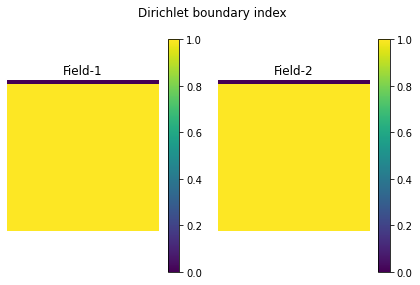

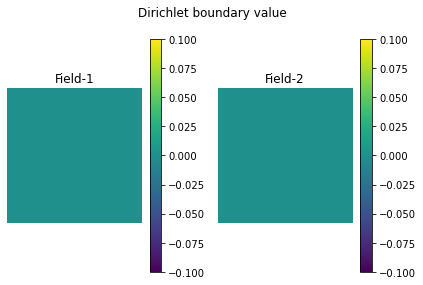

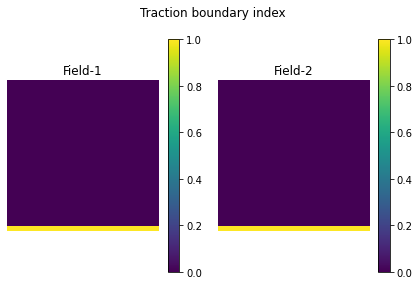

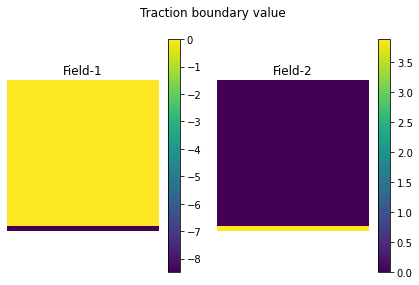

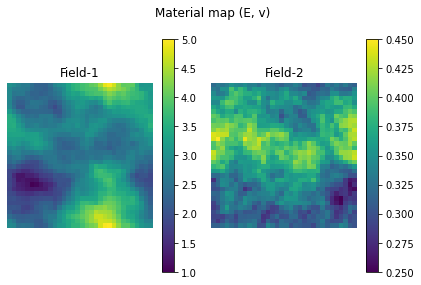

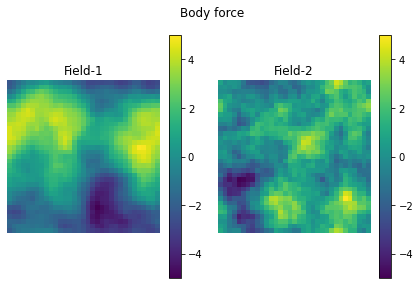

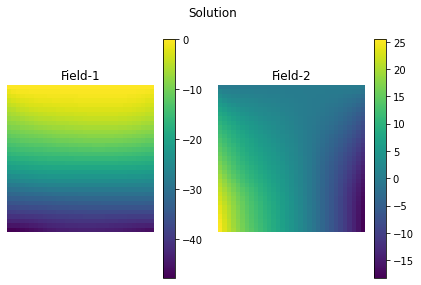

In [12]:
plot.plot_elasticfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(traction_idx_train[k], ftitle='Traction boundary index')
plot.plot_elasticfield(traction_value_train[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_train[k], ftitle='Material map (E, v)')
plot.plot_elasticfield(f_train[k], ftitle='Body force')
plot.plot_elasticfield(u_train[k], ftitle='Solution')

In [13]:
domain_size = 2
n_elem = 2**5
ku, kf = 2, 2
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='elastic')

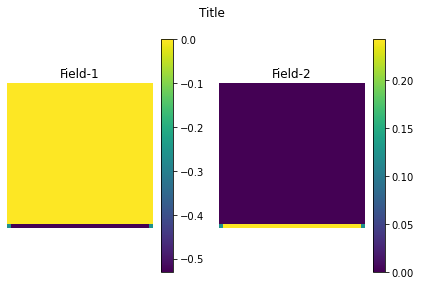

In [14]:
u_test = torch.ones(size=(bs, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double)
u_test = grid.jac.reset_boundary(u_test, dirich_value_train, dirich_idx_train)
residual = grid.model(h, u_test, f_train, traction_value_train, traction_idx_train, material_train)
plot.plot_elasticfield(grid.model.temp3[0])

0 23.37838689402876
1 11.608575226207396
2 8.426284717301986
3 6.830921571260829
4 5.83757918528523
5 5.153195858200853
6 4.6473139833040715
7 4.2575074885749045
8 3.946427393051535
9 3.6921304030239455
10 3.479883933261212
11 3.299907115675557
12 3.1451937122131772
13 3.010707778510458
14 2.892669669851778
15 2.7882124775253923
16 2.695104217571437
17 2.611586022816663
18 2.5362478470355256
19 2.467946536652689
20 2.4057438041810695
21 2.3488620701587006
22 2.29665081211948
23 2.248561404378397
24 2.204127642024263
25 2.1629506864970467
26 2.1246871999006265
27 2.0890399464690756
28 2.055750254537489
29 2.024591930455638
30 1.9953662998877304
31 1.967898140762619
32 1.9420323233094046
33 1.9176310172440052
34 1.8945713561927213
35 1.8727434737486521
36 1.852048843264268
37 1.8323988674957212
38 1.8137136748710192
39 1.795921087573119
40 1.7789557331988486
41 1.7627582769788133
42 1.7472747556917287
43 1.7324559977353962
44 1.7182571164944356
45 1.7046370663143287
46 1.6915582521551924

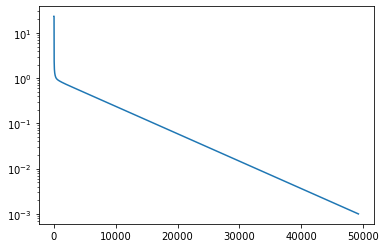

In [15]:
EPS = 1e-3
n_jac = 0
u_test = torch.ones(size=(bs, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double)
u_test = grid.jac.reset_boundary(u_test, dirich_value_train, dirich_idx_train)
residual = grid.model(h, u_test, f_train, traction_value_train, traction_idx_train, material_train)
res = torch.norm(residual[:, :, 1:, :]).item() # fix top, apply traction force at bottom boundary
res_arr = [res]

while (abs(res) > EPS):
    u_test, residual = grid.jac.jacobi_convolution(h, u_test, f_train, traction_value_train, traction_idx_train, dirich_value_train, dirich_idx_train, material_train)
    #residual = grid.model(h, u_test, f_train, traction_value_train, traction_idx_train, material_train)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')


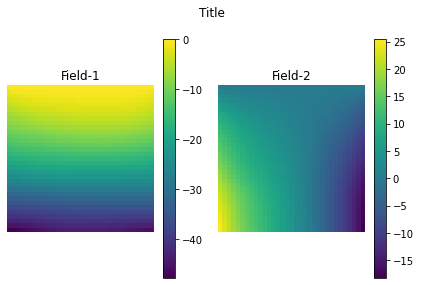

In [16]:
plot.plot_elasticfield(u_test[0])

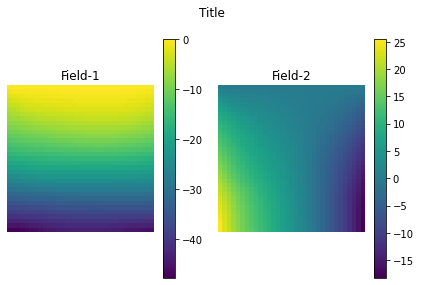

In [17]:
plot.plot_elasticfield(u_train[0])

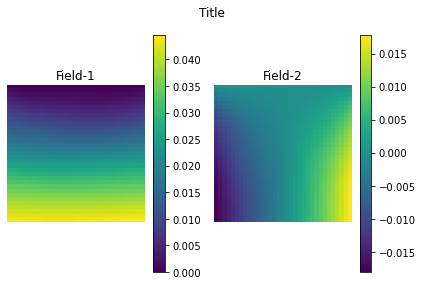

In [18]:
plot.plot_elasticfield(u_test[0]-u_train[0])